# Changes:

1. Use 1st ver UNET
2. Use the Augmentor Package to augment data
3. BCE loss + lovasz loss
4. Bilinear Upsampling
Best Val IOU: 0.8142 at epoch 176

## Install required packages if running on google colab

In [1]:
try:
    import torch
except:
    !pip install torch torchvision
    !pip install imageio
    !pip install Augmentor
    !git clone https://github.com/allen-q/salt_oil.git
    !git clone https://github.com/allen-q/salt_net.git

In [2]:
cd salt_oil/

[WinError 2] The system cannot find the file specified: 'salt_oil/'
C:\work\code\repos\salt_oil


## Import required libs

In [3]:
import zipfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
import math
import datetime as dt
import pytz
import pickle
from salt_func_lib import *
from torchvision import transforms, utils
from skimage import io, transform
import datetime as dt
import sys
from optparse import OptionParser
import torch.backends.cudnn as cudnn
from torch import optim
from torch.optim import lr_scheduler
import copy
from io import BytesIO
import Augmentor
import random
import PIL
% matplotlib inline
% load_ext autoreload
% autoreload 2

## Load Unet Modules

In [4]:
from pytorch_unet.eval import eval_net
from pytorch_unet.unet import UNet
from pytorch_unet.unet.unet_parts import *
from pytorch_unet.utils import get_ids, split_ids, split_train_val, get_imgs_and_masks, batch

In [5]:
## Setup data type based on whether GPU is enabled

In [6]:
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!
else:    
    dtype = torch.FloatTensor

In [7]:
print(f'Data Type set to: {dtype}')

Data Type set to: <class 'torch.FloatTensor'>


## Create Global Variables

In [8]:
def init_global_variables():
    """initialize global variables such as db connection, logger etc."""
    global log
    log = get_logger('SaltNet')

In [9]:
init_global_variables()

In [10]:
class SaltDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, np_img, np_mask, df_depth, mean_img, out_size=101, out_ch=1, transform=None):
        """
        Args:
            data_dir (string): Path to the image files.
            train (bool): Load train or test data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.np_img = np_img
        self.np_mask = np_mask.clip(0,1)
        self.df_depth = df_depth
        self.mean_img = mean_img
        self.out_size = out_size
        self.out_ch = out_ch
        self.transform = transform

    def __len__(self):
        return len(self.np_img)

    def __getitem__(self, idx):

        X_orig = self.np_img[idx]
        #X = X_orig - self.mean_img

        if self.np_mask is None:
            y = np.zeros((101,101,1))
        else:
            y = self.np_mask[idx]

        if self.transform:
            img_in = PIL.Image.fromarray(np.c_[np.tile(X_orig, 2), y*255])
            #img_in = PIL.Image.fromarray(np.tile(y, 3)*255)
            transformed = np.array(self.transform(img_in))
            X = np.clip(transformed[:,:,0:1]/255, 0., 1.) - self.mean_img
            y = np.clip(transformed[:,:,2:3]/255, 0., 1.)
        else:
            X = np.clip(X_orig/255, 0., 1.) - self.mean_img

        #print(X.dtype)
        
        X = np.moveaxis(X, -1,0)

        pad_size = self.out_size - X.shape[2]
        pad_first = pad_size//2
        pad_last = pad_size - pad_first
        X = np.pad(X, [(0, 0),(pad_first, pad_last), (pad_first, pad_last)], mode='reflect')
        #print(X.dtype)

        d = self.df_depth.iloc[idx,0]
        #id = self.df_depth.index[idx]
        #from boxx import g
        #g()
        X = torch.from_numpy(X).float().type(dtype)
        X = X.repeat(self.out_ch,1,1)
        y = transform.resize(y, (101, 101), mode='constant', preserve_range=True)
        y = torch.from_numpy(y).float().squeeze().type(dtype)

        return (X,y,d,idx)

In [11]:
class Pipeline_Salt(Augmentor.Pipeline):
    def __init__(self, source_directory=None, output_directory="output", save_format=None):
        super(Pipeline_Salt, self).__init__(source_directory, output_directory, save_format)

    def torch_transform(self):
        """
        Returns the pipeline as a function that can be used with torchvision.

        .. code-block:: python

            >>> import Augmentor
            >>> import torchvision
            >>> p = Augmentor.Pipeline()
            >>> p.rotate(probability=0.7, max_left_rotate=10, max_right_rotate=10)
            >>> p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
            >>> transforms = torchvision.transforms.Compose([
            >>>     p.torch_transform(),
            >>>     torchvision.transforms.ToTensor(),
            >>> ])

        :return: The pipeline as a function.
        """
        def _transform(image):
            for operation in self.operations:
                r = round(random.uniform(0, 1), 1)
                if r <= operation.probability:
                    if not isinstance(image, list):
                        image = [image]
                    image = operation.perform_operation(image)[0]

            return image

        return _transform

## Prepare Data

### Load train and test data from npy files or from raw images if npy files not exist.

In [12]:
np_train_all, np_train_all_mask, X_test, misc_data = load_all_data()

Try loading data from npy and pickle files...
Data loaded.


### Remove black images

In [13]:
#black_img_ids = (np_train_all.max((1,2,3))==0)

#np_train_all = np_train_all[~black_img_ids]
#np_train_all_mask = np_train_all_mask[~black_img_ids]

In [14]:
np_train_all.shape

(4000, 101, 101, 1)

### Remove images with all black masks

In [15]:
#black_mask_ids = (np_train_all_mask.max((1,2,3))==0)
#np_train_all = np_train_all[~black_mask_ids]
#np_train_all_mask = np_train_all_mask[~black_mask_ids]

### Train Val data split

In [16]:
#np_train_all = np.clip(np_train_all/255, 0, 1)
#X_test = np.clip(X_test/255, 0, 1)

In [17]:
X_train_ids, X_val_ids = (
    train_test_split(np.arange(len(np_train_all)), 
                     test_size=0.20, 
                     random_state=42)
)

In [18]:
X_train = np_train_all[X_train_ids]
X_val = np_train_all[X_val_ids]
y_train = np_train_all_mask[X_train_ids]
y_val = np_train_all_mask[X_val_ids]
depth_train = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_train_ids])
)
depth_val = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_val_ids])
)
depth_test = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_test_ids']))
)
#X_train_mean_img = X_train.mean(0).astype(np.float32)
#X_train_mean_img = X_train.mean((0,1,2)).astype(np.float32)
X_train_mean_img = np.clip(np_train_all/255, 0, 1).mean((0,1,2)).astype(np.float32)

all_data = {
    'X_train': X_train,
    'X_val': X_val,
    'y_train': y_train,
    'y_val': y_val,
    'X_test': X_test,
    'X_train_mean_img': X_train_mean_img
}

In [19]:
X_train_mean_img

array([0.47194558], dtype=float32)

In [20]:
p = Pipeline_Salt()

In [21]:

#p.skew(probability=1, magnitude=0.5)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=5)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.0, max_factor=1.2)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)
p.crop_by_size(probability=0.5, width=101, height=101, centre=False)


### Create a Train Dataloader

In [22]:
'''composed_tsfm = transforms.Compose([Rescale(scale='random', min_scale=1, max_scale=2),
                                    RandomCrop(101),
                                    Flip(orient='random')])'''

data_params = {'batch_size': 32,
               'shuffle': True,
               'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           X_train_mean_img, out_size=128,  out_ch=1,
                           transform=p.torch_transform()), **data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           X_train_mean_img, out_size=128, out_ch=1), **data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

sample = iter(dataloaders['train']).__next__()

assert sample[0].shape == torch.Size([data_params['batch_size'], 1, 128, 128])
assert sample[1].shape == torch.Size([data_params['batch_size'], 101, 101])
assert sample[2].shape == torch.Size([data_params['batch_size']])
assert sample[3].shape == torch.Size([data_params['batch_size']])

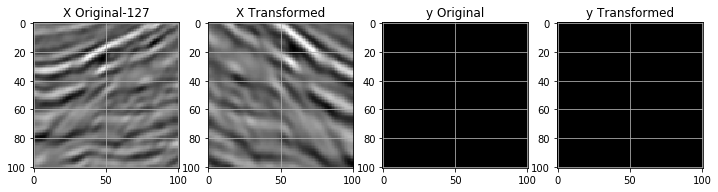

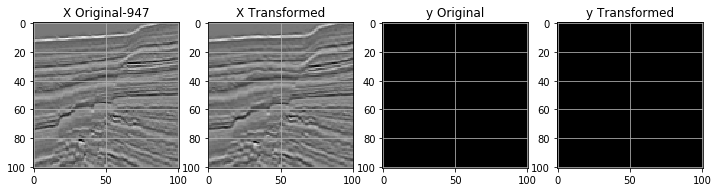

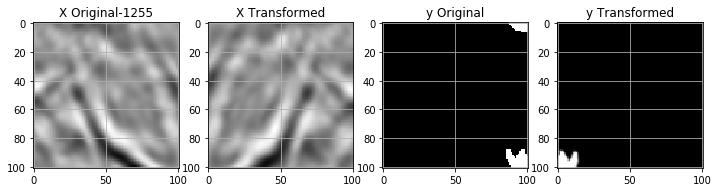

In [23]:
i = 0
for X_batch, y_batch, d_batch, X_id in dataloaders['train']:
    i+=1
    if i>3:
        break
    X_orig = X_train[X_id[0]].squeeze()/255
    X_tsfm = X_batch[0,0].squeeze().cpu().detach().numpy()[13:114,13:114] + X_train_mean_img.squeeze()
    y_orig = y_train[X_id[0]].squeeze()
    y_tsfm = (y_batch[0].squeeze().cpu().detach().numpy())
    plot_img_mask_pred([X_orig, X_tsfm, y_orig, y_tsfm],
                       [f'X Original-{X_id[0]}', 'X Transformed', 'y Original', 'y Transformed'])

In [24]:
X_train.shape

(3200, 101, 101, 1)

### Create a Train Dataloader for sanity check

In [35]:
data_params = {'batch_size': 2,
               'shuffle': False,
               'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train[:8], y_train[:8], depth_train[:8],
                           X_train_mean_img, out_size=128, out_ch=1,
                           transform=None), **data_params)
                           #transform=p.torch_transform()), **data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val[:4], y_val[:4], depth_val[:4], 
                           X_train_mean_img, out_size=128, out_ch=1), **data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}


In [26]:
t = iter(train_dataLoader).__next__()

In [27]:
X_batch, y_batch, d_batch, X_id = t

In [30]:
def train_model(model, dataloaders, criterion1, criterion2, optimizer, scheduler, model_save_name, other_data={}, 
                num_epochs=25, print_every=2, save_model_every=None, save_log_every=None, log=get_logger('SaltNet'), loss2_weight=0):
    #args = locals()
    #args = {k:v.shape if isinstance(v, (torch.Tensor, np.ndarray)) else v for k,v in args.items()}
    #args = {k:v.shape if isinstance(v, (torch.Tensor, np.ndarray)) else v for k,v in args.items()}
    log.info('Start Training...')
    #log.info('Passed parameters: {}'.format(args))

    start = time.time()

    if torch.cuda.is_available():
        model.cuda()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_model = None
    best_iou = 0.0
    all_losses = []
    iter_count = 0
    X_train = other_data['X_train']
    X_val = other_data['X_val']
    y_train = other_data['y_train']
    y_val = other_data['y_val']
    X_train_mean_img = other_data['X_train_mean_img']
    mask_cutoff = 0.

    for epoch in range(1, num_epochs+1):
        log.info('Epoch {}/{}'.format(epoch, num_epochs))
        log.info('-' * 20)
        if save_log_every is not None:
            if (epoch % save_log_every == 0):
                push_log_to_git()
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_loss1 = []
            epoch_loss2 = []
            pred_vs_true_epoch = []

            for X_batch, y_batch, d_batch, X_id in dataloaders[phase]:
                # zero the parameter gradients
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    #y_pred, y_mask_pred = model(X_batch)
                    y_pred = model(X_batch)
                    pred_vs_true_epoch.append([y_pred, y_batch])
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':                        
                        #from boxx import g
                        #g()
                        loss_1 = criterion1(y_pred, y_batch.float())      
                        loss_2 = loss2_weight * criterion2(y_pred, y_batch.float()) 

                        #print(f'loss_pix: {loss_pix}, loss_dice:{loss_dice}')
                        loss = loss_1 + loss_2
                        #loss = loss_pix
                        all_losses.append(loss.item())
                        epoch_loss1.append(loss_1.item())
                        epoch_loss2.append(loss_2.item())
                        
                        loss.backward()
                        optimizer.step()
                        iter_count += 1
                if (phase == 'train') & (iter_count % print_every == 0):
                    iou_batch = calc_mean_iou(y_pred.ge(mask_cutoff), y_batch.float())
                    iou_acc = calc_clf_accuracy(y_pred.ge(mask_cutoff), y_batch.float())

                    log.info('Batch Loss: {:.4f}, Epoch loss_1: {:.4f}, Epoch loss_2: {:.4f}, Batch IOU: {:.4f}, Batch Acc: {:.4f} at iter {}, epoch {}, Time: {}'.format(
                        np.mean(all_losses[-print_every:]), np.mean(epoch_loss1), np.mean(epoch_loss2), iou_batch, iou_acc, iter_count, epoch, timeSince(start))
                    )
                    #print(all_losses)
                    X_orig = X_train[X_id[0]].squeeze()/255
                    X_tsfm = X_batch[0,0].squeeze().cpu().detach().numpy()
                    X_tsfm = transform.resize(X_tsfm, (128, 128), mode='constant', preserve_range=True)
                    X_tsfm = X_tsfm[13:114,13:114] + X_train_mean_img.squeeze()
                    #X_tsfm = X_batch[0][X_batch[0].sum((1,2)).argmax()].squeeze().cpu().detach().numpy()[:101,:101] + X_train_mean_img.squeeze()

                    y_orig = y_train[X_id[0]].squeeze()
                    y_tsfm = (y_batch[0].squeeze().cpu().detach().numpy())
                    y_tsfm_pred =  y_pred[0].squeeze().gt(mask_cutoff)
                    plot_img_mask_pred([X_orig, X_tsfm, y_orig, y_tsfm, y_tsfm_pred],
                                       ['X Original', 'X Transformed', 'y Original', 'y Transformed', 'y Predicted'])

            y_pred_epoch = torch.cat([e[0] for e in pred_vs_true_epoch])
            y_true_epoch = torch.cat([e[1] for e in pred_vs_true_epoch])
            #from boxx import g
            #g()
            mean_iou_epoch = calc_mean_iou(y_pred_epoch.ge(mask_cutoff), y_true_epoch.float())
            mean_acc_epoch = calc_clf_accuracy(y_pred_epoch.ge(mask_cutoff), y_true_epoch.float())
            log.info('{} Mean IOU: {:.4f}, Mean Acc: {:.4f}, Best Val IOU: {:.4f} at epoch {}'.format(phase, mean_iou_epoch, mean_acc_epoch, best_iou, epoch))
            if phase == 'val' and mean_iou_epoch > best_iou:
                best_iou = mean_iou_epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                stats = {'best_iou': best_iou,
                         'all_losses': all_losses,
                         'iter_count': iter_count}
                log.info(save_model_state_to_chunks(epoch, copy.deepcopy(model.state_dict()),
                                                    copy.deepcopy(optimizer.state_dict()),
                                                    copy.deepcopy(scheduler.state_dict()), stats, model_save_name, '.'))
                best_model = (epoch, copy.deepcopy(model.state_dict()),
                                                    copy.deepcopy(optimizer.state_dict()),
                                                    copy.deepcopy(scheduler.state_dict()), stats, model_save_name, '.')
                log.info('Best Val Mean IOU so far: {}'.format(best_iou))
                # Visualize 1 val sample and predictions
                X_orig = X_val[X_id[0]].squeeze()/255
                y_orig = y_val[X_id[0]].squeeze()
                y_pred2 =  y_pred[0].squeeze().gt(mask_cutoff)
                plot_img_mask_pred([X_orig, y_orig, y_pred2],
                                   ['Val X Original', 'Val y Original', 'Val y Predicted'])
        if save_model_every is not None:
            if (epoch % save_model_every == 0) | (epoch == num_epochs-1):
                if (best_model is not None) and (best_iou>0.80):
                    log.info(save_model_state_to_chunks(*best_model))                
                    push_model_to_git(ckp_name=model_save_name)
                    best_model = None
                else:
                    log.info("Skip pushing model to git as there's no improvement")

    # load best model weights
    model.load_state_dict(best_model_wts)
    log.info('-' * 20)
    time_elapsed = time.time() - start
    log.info('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    log.info('Best val IOU: {:4f}'.format(best_iou))

    return model

## Train the model using a small data set to see if it can overfit

In [29]:
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)

Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling


08/09/2018 23:49:02 - SaltNet - INFO - Start Training...
08/09/2018 23:49:02 - SaltNet - INFO - Epoch 1/100
08/09/2018 23:49:02 - SaltNet - INFO - --------------------
c:\users\allen\anaconda3\envs\ds\lib\site-packages\torch\nn\modules\upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
c:\users\allen\anaconda3\envs\ds\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
08/09/2018 23:49:11 - SaltNet - INFO - Batch Loss: 0.0431, Epoch loss_1: 0.0431, Epoch loss_2: 0.0000, Batch IOU: 0.0000, Batch Acc: 0.4487 at iter 2, epoch 1, Time: 0m 9s


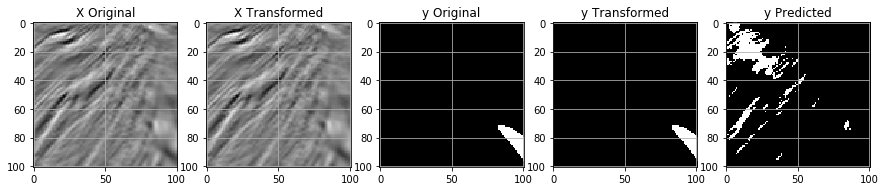

08/09/2018 23:49:23 - SaltNet - INFO - Batch Loss: 0.0358, Epoch loss_1: 0.0395, Epoch loss_2: 0.0000, Batch IOU: 0.0000, Batch Acc: 0.7110 at iter 4, epoch 1, Time: 0m 20s


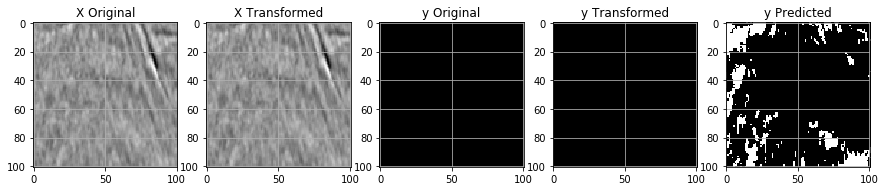

08/09/2018 23:49:24 - SaltNet - INFO - train Mean IOU: 0.0000, Mean Acc: 0.6144, Best Val IOU: 0.0000 at epoch 1
08/09/2018 23:49:28 - SaltNet - INFO - val Mean IOU: 0.7500, Mean Acc: 0.8981, Best Val IOU: 0.0000 at epoch 1
08/09/2018 23:49:29 - SaltNet - INFO - Model state is not saved as the out_file_prefix is None
08/09/2018 23:49:29 - SaltNet - INFO - Best Val Mean IOU so far: 0.75


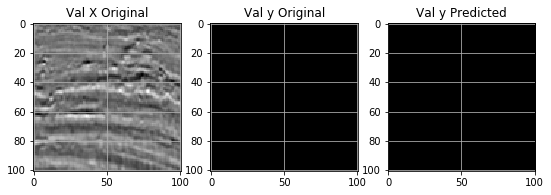

08/09/2018 23:49:30 - SaltNet - INFO - Epoch 2/100
08/09/2018 23:49:30 - SaltNet - INFO - --------------------
08/09/2018 23:49:42 - SaltNet - INFO - Batch Loss: 0.0354, Epoch loss_1: 0.0354, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.9809 at iter 6, epoch 2, Time: 0m 40s


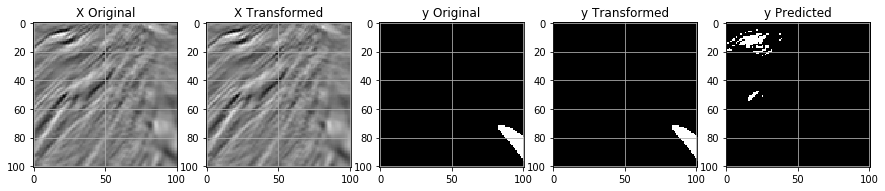

08/09/2018 23:49:54 - SaltNet - INFO - Batch Loss: 0.0318, Epoch loss_1: 0.0336, Epoch loss_2: 0.0000, Batch IOU: 0.0000, Batch Acc: 0.7970 at iter 8, epoch 2, Time: 0m 52s


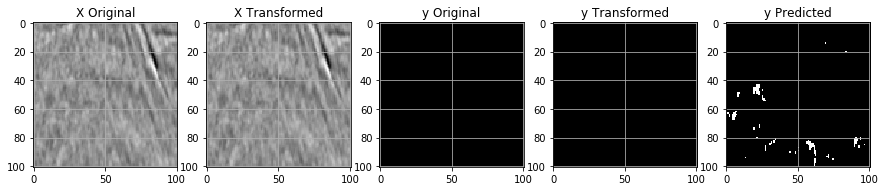

08/09/2018 23:49:55 - SaltNet - INFO - train Mean IOU: 0.1250, Mean Acc: 0.8363, Best Val IOU: 0.7500 at epoch 2
08/09/2018 23:50:00 - SaltNet - INFO - val Mean IOU: 0.7500, Mean Acc: 0.8981, Best Val IOU: 0.7500 at epoch 2
08/09/2018 23:50:00 - SaltNet - INFO - Epoch 3/100
08/09/2018 23:50:00 - SaltNet - INFO - --------------------
08/09/2018 23:50:12 - SaltNet - INFO - Batch Loss: 0.0328, Epoch loss_1: 0.0328, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.9846 at iter 10, epoch 3, Time: 1m 10s


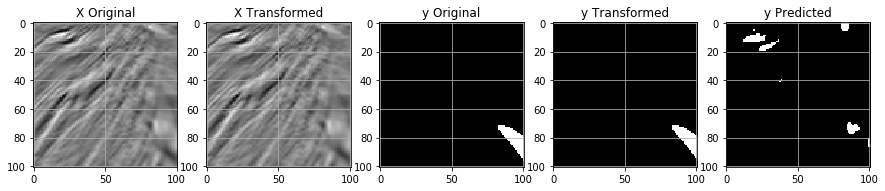

08/09/2018 23:50:24 - SaltNet - INFO - Batch Loss: 0.0284, Epoch loss_1: 0.0306, Epoch loss_2: 0.0000, Batch IOU: 0.0000, Batch Acc: 0.7960 at iter 12, epoch 3, Time: 1m 22s


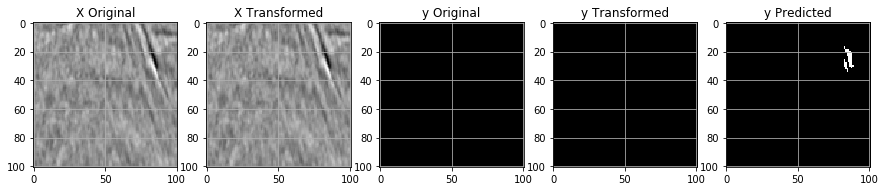

08/09/2018 23:50:25 - SaltNet - INFO - train Mean IOU: 0.1250, Mean Acc: 0.8715, Best Val IOU: 0.7500 at epoch 3
08/09/2018 23:50:30 - SaltNet - INFO - val Mean IOU: 0.7500, Mean Acc: 0.8981, Best Val IOU: 0.7500 at epoch 3
08/09/2018 23:50:30 - SaltNet - INFO - Epoch 4/100
08/09/2018 23:50:30 - SaltNet - INFO - --------------------
08/09/2018 23:50:43 - SaltNet - INFO - Batch Loss: 0.0271, Epoch loss_1: 0.0271, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.9758 at iter 14, epoch 4, Time: 1m 41s


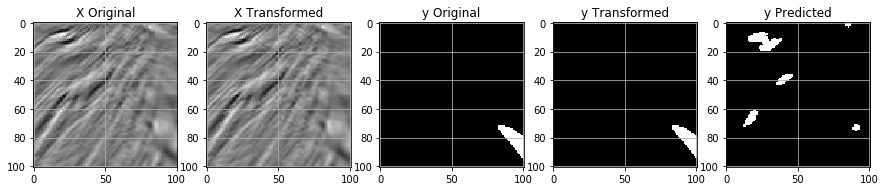

08/09/2018 23:50:57 - SaltNet - INFO - Batch Loss: 0.0249, Epoch loss_1: 0.0260, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.8030 at iter 16, epoch 4, Time: 1m 55s


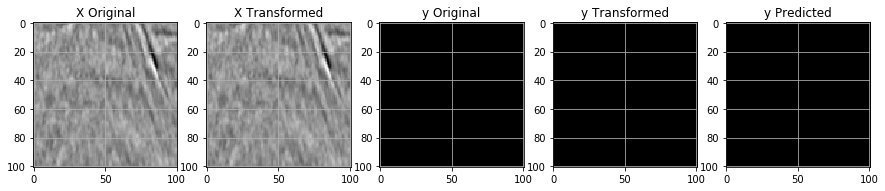

08/09/2018 23:50:58 - SaltNet - INFO - train Mean IOU: 0.3750, Mean Acc: 0.8774, Best Val IOU: 0.7500 at epoch 4
08/09/2018 23:51:04 - SaltNet - INFO - val Mean IOU: 0.7500, Mean Acc: 0.8981, Best Val IOU: 0.7500 at epoch 4
08/09/2018 23:51:04 - SaltNet - INFO - Epoch 5/100
08/09/2018 23:51:04 - SaltNet - INFO - --------------------
08/09/2018 23:51:15 - SaltNet - INFO - Batch Loss: 0.0241, Epoch loss_1: 0.0241, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.9901 at iter 18, epoch 5, Time: 2m 13s


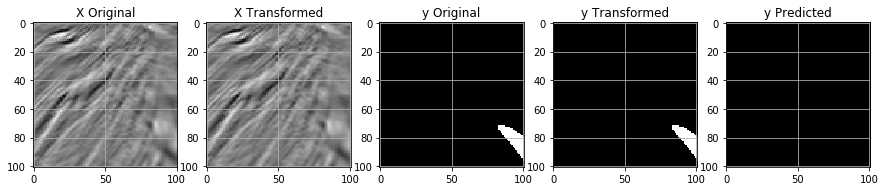

08/09/2018 23:51:28 - SaltNet - INFO - Batch Loss: 0.0215, Epoch loss_1: 0.0228, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.8790 at iter 20, epoch 5, Time: 2m 25s


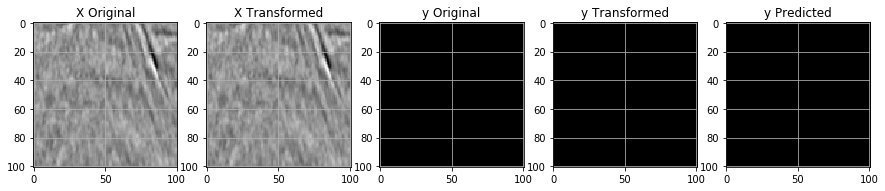

08/09/2018 23:51:28 - SaltNet - INFO - train Mean IOU: 0.2500, Mean Acc: 0.8899, Best Val IOU: 0.7500 at epoch 5
08/09/2018 23:51:34 - SaltNet - INFO - val Mean IOU: 0.7500, Mean Acc: 0.8981, Best Val IOU: 0.7500 at epoch 5
08/09/2018 23:51:34 - SaltNet - INFO - Epoch 6/100
08/09/2018 23:51:34 - SaltNet - INFO - --------------------
08/09/2018 23:51:45 - SaltNet - INFO - Batch Loss: 0.0222, Epoch loss_1: 0.0222, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.9888 at iter 22, epoch 6, Time: 2m 43s


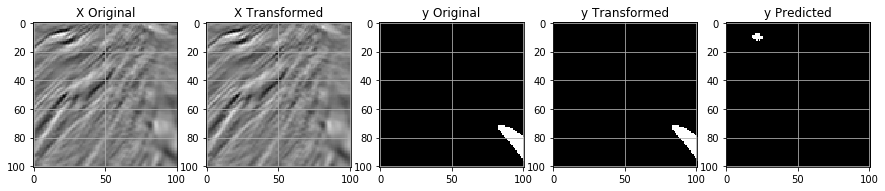

08/09/2018 23:51:57 - SaltNet - INFO - Batch Loss: 0.0221, Epoch loss_1: 0.0221, Epoch loss_2: 0.0000, Batch IOU: 0.0000, Batch Acc: 0.8567 at iter 24, epoch 6, Time: 2m 55s


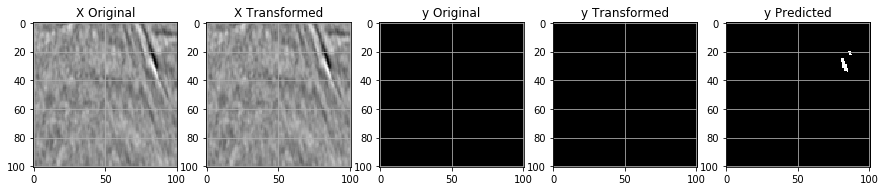

08/09/2018 23:51:58 - SaltNet - INFO - train Mean IOU: 0.1250, Mean Acc: 0.8855, Best Val IOU: 0.7500 at epoch 6
08/09/2018 23:52:03 - SaltNet - INFO - val Mean IOU: 0.5000, Mean Acc: 0.8862, Best Val IOU: 0.7500 at epoch 6
08/09/2018 23:52:03 - SaltNet - INFO - Epoch 7/100
08/09/2018 23:52:03 - SaltNet - INFO - --------------------
08/09/2018 23:52:15 - SaltNet - INFO - Batch Loss: 0.0199, Epoch loss_1: 0.0199, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.9876 at iter 26, epoch 7, Time: 3m 12s


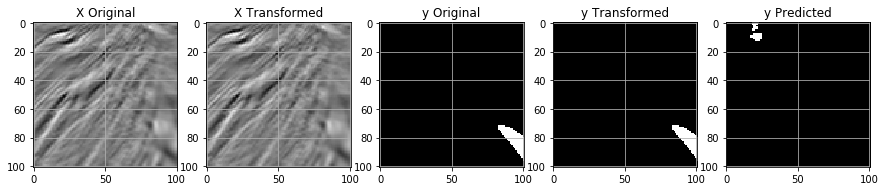

08/09/2018 23:52:27 - SaltNet - INFO - Batch Loss: 0.0188, Epoch loss_1: 0.0194, Epoch loss_2: 0.0000, Batch IOU: 0.0000, Batch Acc: 0.8836 at iter 28, epoch 7, Time: 3m 25s


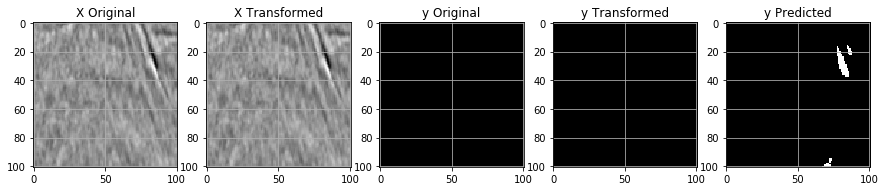

08/09/2018 23:52:28 - SaltNet - INFO - train Mean IOU: 0.1375, Mean Acc: 0.9076, Best Val IOU: 0.7500 at epoch 7
08/09/2018 23:52:33 - SaltNet - INFO - val Mean IOU: 0.0000, Mean Acc: 0.8486, Best Val IOU: 0.7500 at epoch 7
08/09/2018 23:52:33 - SaltNet - INFO - Epoch 8/100
08/09/2018 23:52:33 - SaltNet - INFO - --------------------
08/09/2018 23:52:48 - SaltNet - INFO - Batch Loss: 0.0166, Epoch loss_1: 0.0166, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.9885 at iter 30, epoch 8, Time: 3m 46s


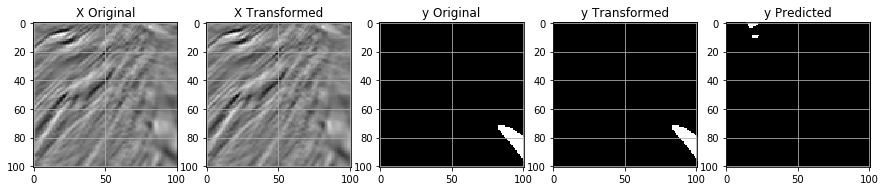

08/09/2018 23:53:01 - SaltNet - INFO - Batch Loss: 0.0157, Epoch loss_1: 0.0161, Epoch loss_2: 0.0000, Batch IOU: 0.7000, Batch Acc: 0.9297 at iter 32, epoch 8, Time: 3m 59s


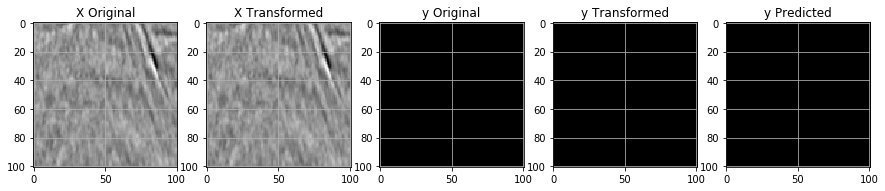

08/09/2018 23:53:03 - SaltNet - INFO - train Mean IOU: 0.3625, Mean Acc: 0.9281, Best Val IOU: 0.7500 at epoch 8
08/09/2018 23:53:09 - SaltNet - INFO - val Mean IOU: 0.0000, Mean Acc: 0.7831, Best Val IOU: 0.7500 at epoch 8
08/09/2018 23:53:09 - SaltNet - INFO - Epoch 9/100
08/09/2018 23:53:09 - SaltNet - INFO - --------------------
08/09/2018 23:53:28 - SaltNet - INFO - Batch Loss: 0.0142, Epoch loss_1: 0.0142, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.9849 at iter 34, epoch 9, Time: 4m 26s


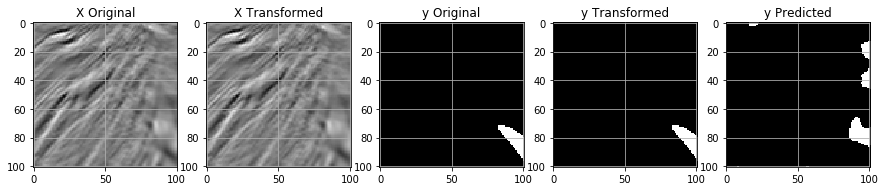

08/09/2018 23:53:42 - SaltNet - INFO - Batch Loss: 0.0134, Epoch loss_1: 0.0138, Epoch loss_2: 0.0000, Batch IOU: 0.3000, Batch Acc: 0.9507 at iter 36, epoch 9, Time: 4m 40s


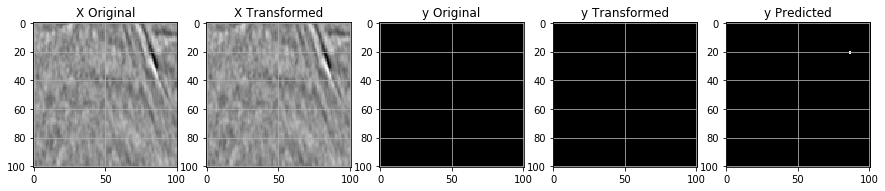

08/09/2018 23:53:43 - SaltNet - INFO - train Mean IOU: 0.3000, Mean Acc: 0.9458, Best Val IOU: 0.7500 at epoch 9
08/09/2018 23:53:50 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.8391, Best Val IOU: 0.7500 at epoch 9
08/09/2018 23:53:50 - SaltNet - INFO - Epoch 10/100
08/09/2018 23:53:50 - SaltNet - INFO - --------------------
08/09/2018 23:54:03 - SaltNet - INFO - Batch Loss: 0.0117, Epoch loss_1: 0.0117, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.9910 at iter 38, epoch 10, Time: 5m 1s


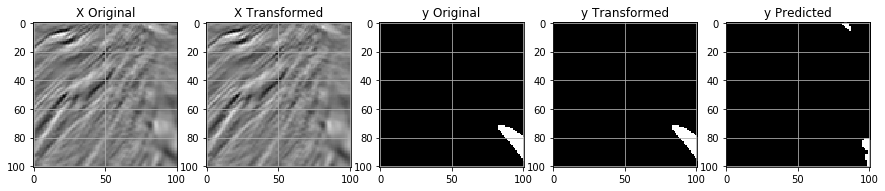

08/09/2018 23:54:18 - SaltNet - INFO - Batch Loss: 0.0117, Epoch loss_1: 0.0117, Epoch loss_2: 0.0000, Batch IOU: 0.8000, Batch Acc: 0.9576 at iter 40, epoch 10, Time: 5m 16s


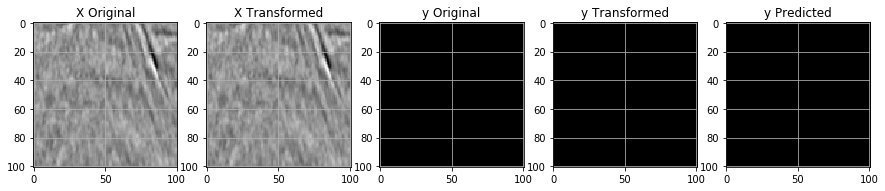

08/09/2018 23:54:19 - SaltNet - INFO - train Mean IOU: 0.4250, Mean Acc: 0.9495, Best Val IOU: 0.7500 at epoch 10
08/09/2018 23:54:28 - SaltNet - INFO - val Mean IOU: 0.5000, Mean Acc: 0.8683, Best Val IOU: 0.7500 at epoch 10
08/09/2018 23:54:28 - SaltNet - INFO - Epoch 11/100
08/09/2018 23:54:28 - SaltNet - INFO - --------------------
08/09/2018 23:54:47 - SaltNet - INFO - Batch Loss: 0.0094, Epoch loss_1: 0.0094, Epoch loss_2: 0.0000, Batch IOU: 0.0500, Batch Acc: 0.9930 at iter 42, epoch 11, Time: 5m 45s


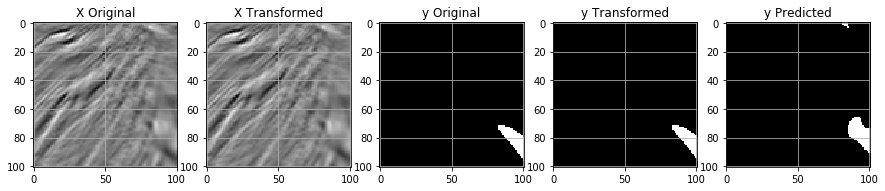

08/09/2018 23:55:06 - SaltNet - INFO - Batch Loss: 0.0100, Epoch loss_1: 0.0097, Epoch loss_2: 0.0000, Batch IOU: 0.3000, Batch Acc: 0.9573 at iter 44, epoch 11, Time: 6m 3s


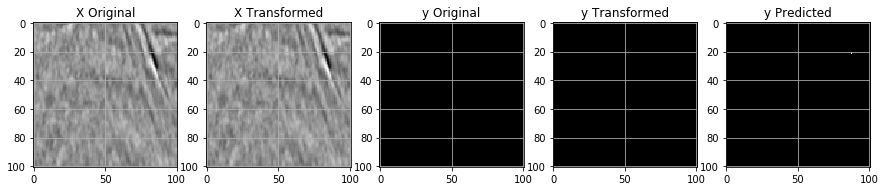

08/09/2018 23:55:07 - SaltNet - INFO - train Mean IOU: 0.2250, Mean Acc: 0.9584, Best Val IOU: 0.7500 at epoch 11
08/09/2018 23:55:13 - SaltNet - INFO - val Mean IOU: 0.5000, Mean Acc: 0.8979, Best Val IOU: 0.7500 at epoch 11
08/09/2018 23:55:13 - SaltNet - INFO - Epoch 12/100
08/09/2018 23:55:13 - SaltNet - INFO - --------------------
08/09/2018 23:55:27 - SaltNet - INFO - Batch Loss: 0.0116, Epoch loss_1: 0.0116, Epoch loss_2: 0.0000, Batch IOU: 0.2500, Batch Acc: 0.9968 at iter 46, epoch 12, Time: 6m 24s


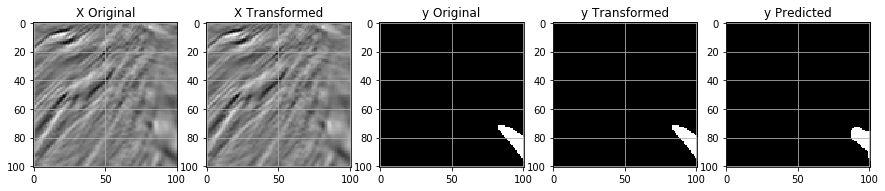

08/09/2018 23:55:42 - SaltNet - INFO - Batch Loss: 0.0143, Epoch loss_1: 0.0129, Epoch loss_2: 0.0000, Batch IOU: 0.2000, Batch Acc: 0.9097 at iter 48, epoch 12, Time: 6m 40s


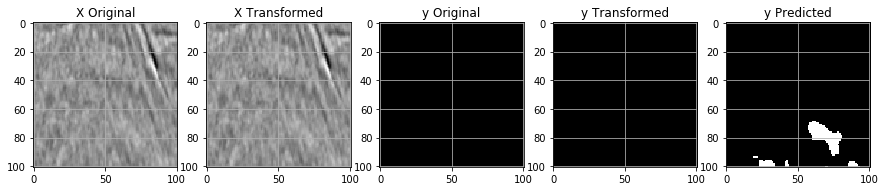

08/09/2018 23:55:43 - SaltNet - INFO - train Mean IOU: 0.1625, Mean Acc: 0.9222, Best Val IOU: 0.7500 at epoch 12
08/09/2018 23:55:50 - SaltNet - INFO - val Mean IOU: 0.0000, Mean Acc: 0.2871, Best Val IOU: 0.7500 at epoch 12
08/09/2018 23:55:50 - SaltNet - INFO - Epoch 13/100
08/09/2018 23:55:50 - SaltNet - INFO - --------------------
08/09/2018 23:56:04 - SaltNet - INFO - Batch Loss: 0.0289, Epoch loss_1: 0.0289, Epoch loss_2: 0.0000, Batch IOU: 0.1500, Batch Acc: 0.5111 at iter 50, epoch 13, Time: 7m 2s


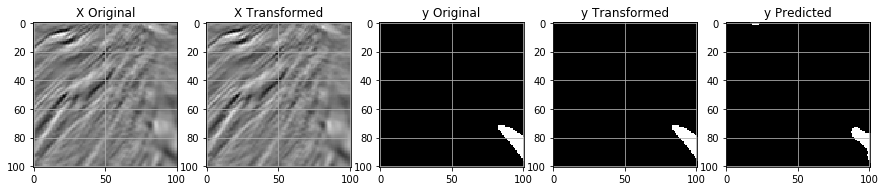

08/09/2018 23:56:19 - SaltNet - INFO - Batch Loss: 0.0115, Epoch loss_1: 0.0202, Epoch loss_2: 0.0000, Batch IOU: 0.8500, Batch Acc: 0.9567 at iter 52, epoch 13, Time: 7m 17s


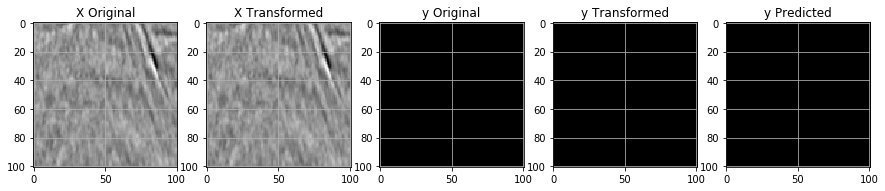

08/09/2018 23:56:20 - SaltNet - INFO - train Mean IOU: 0.2750, Mean Acc: 0.8080, Best Val IOU: 0.7500 at epoch 13
08/09/2018 23:56:26 - SaltNet - INFO - val Mean IOU: 0.2500, Mean Acc: 0.8485, Best Val IOU: 0.7500 at epoch 13
08/09/2018 23:56:26 - SaltNet - INFO - Epoch 14/100
08/09/2018 23:56:26 - SaltNet - INFO - --------------------
08/09/2018 23:56:40 - SaltNet - INFO - Batch Loss: 0.0102, Epoch loss_1: 0.0102, Epoch loss_2: 0.0000, Batch IOU: 0.5000, Batch Acc: 0.9851 at iter 54, epoch 14, Time: 7m 38s


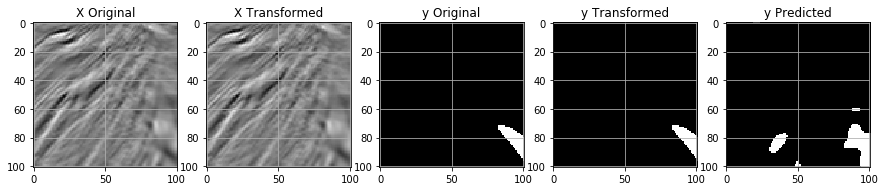

08/09/2018 23:56:59 - SaltNet - INFO - Batch Loss: 0.0100, Epoch loss_1: 0.0101, Epoch loss_2: 0.0000, Batch IOU: 0.2500, Batch Acc: 0.9470 at iter 56, epoch 14, Time: 7m 56s


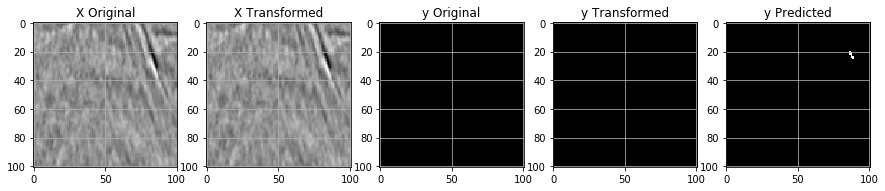

08/09/2018 23:57:01 - SaltNet - INFO - train Mean IOU: 0.3125, Mean Acc: 0.9614, Best Val IOU: 0.7500 at epoch 14
08/09/2018 23:57:08 - SaltNet - INFO - val Mean IOU: 0.5000, Mean Acc: 0.9240, Best Val IOU: 0.7500 at epoch 14
08/09/2018 23:57:08 - SaltNet - INFO - Epoch 15/100
08/09/2018 23:57:08 - SaltNet - INFO - --------------------


KeyboardInterrupt: 

In [36]:
#saltnet = resnet34unet(in_ch=3, bilinear=False, pretrained=False)

#loss_fn_bce = nn.BCEWithLogitsLoss()
loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()

optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

model_save_name = None

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_focal, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=100, print_every=2, save_model_every=None, save_log_every=None, log=log, loss2_weight=0.0)

In [38]:
y_train.shape

(3200, 101, 101, 1)

(array([1707.,  235.,  182.,  145.,  186.,  156.,  146.,  117.,  125.,
         201.]),
 array([    0.,  1020.,  2040.,  3060.,  4080.,  5100.,  6120.,  7140.,
         8160.,  9180., 10200.]),
 <a list of 10 Patch objects>)

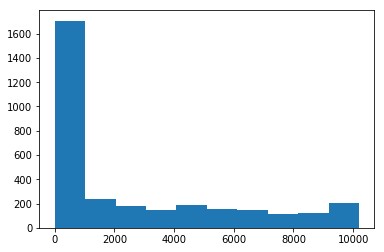

In [50]:
plt.hist((y_train/255).sum((1,2,3)))

In [44]:
y_batch.shape

torch.Size([16, 101, 101])

In [45]:
y_batch.sum((1,2))

tensor([4073., 1485.,  192.,    0.,    0.,    0.,    0., 3957., 1427.,    0.,
        9502.,    0., 1339.,  288.,    0., 4804.])

In [47]:
y_batch_mask_pix = y_batch.sum((1,2))

In [48]:
if y_batch_mask_pix < 101*2:
    pos_weight = 1
elif y_batch_mask_pix > 101*80:
    pos_weight = 1
else:
    pos_weight = y_batch_mask_pix

10201

In [70]:
torch.where((y_batch_mask_pix<202) | (y_batch_mask_pix>5000), torch.tensor(1.0), (101**2/y_batch_mask_pix))

tensor([ 2.5045,  6.8694,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  2.5780,
         7.1486,  1.0000,  1.0000,  1.0000,  7.6184, 35.4201,  1.0000,  2.1234])

In [ ]:
(0.5/0.8)**2

## Train the full with full dataset

In [ ]:
'''saltnet = UNet(n_channels=1, n_classes=1, pred_overall_mask=False, bilinear=False)
model_file_suffix = "../salt_net/Unet_focal_loss_fine_tune_2018_09_01_14_31_09.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])'''

'saltnet = UNet(n_channels=1, n_classes=1, pred_overall_mask=False, bilinear=False)\nmodel_file_suffix = "../salt_net/Unet_focal_loss_fine_tune_2018_09_01_14_31_09.ckp"\nmodel_state_dict = torch.load(join_files(model_file_suffix, \'.\', returnFileObject=True, removeChunks=False))\nsaltnet.load_state_dict(model_state_dict[\'model\'])'

In [ ]:
saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)
loss_fn_bce = nn.BCEWithLogitsLoss()
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)

model_save_name = f'../salt_net/Unet_bce_loss_lovasz_loss_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

# Test Run
trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
                other_data=all_data, num_epochs=250, print_every=50, save_model_every=20, save_log_every=2, log=log)

05/09/2018 13:54:40 - SaltNet - INFO - ../salt_net/Unet_bce_loss_lovasz_loss_2018_09_05_23_54_40.ckp
05/09/2018 13:54:40 - SaltNet - INFO - Start Training...
05/09/2018 13:54:40 - SaltNet - INFO - Epoch 1/250
05/09/2018 13:54:40 - SaltNet - INFO - --------------------


Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


## Load Trained Model

In [24]:
loaded_model = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True)

Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling
Using bilinear for upsampling


In [26]:
cd ../salt_net

/content/salt_net


In [ ]:
model_file_suffix = "Unet_bce_loss_lovasz_loss_2018_09_05_23_54_40.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
loaded_model.load_state_dict(model_state_dict['model'])

### Make Predictions on validation set

### Set model to evaluation mode

In [ ]:
loaded_model.eval()
assert loaded_model.training == False

In [ ]:
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img, out_size=128), batch_size=16)

In [ ]:
if torch.cuda.is_available():
    loaded_model.cuda()

In [33]:
y_val_pred = []

with torch.no_grad():
    for X_val_batch, y_val_batch, depth_val_batch, X_val_id_batch in val_dataLoader:
        y_val_pred.append(loaded_model(X_val_batch))
y_val_pred = torch.cat(y_val_pred)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [34]:
train_dataLoader = DataLoader(SaltDataset(X_train, y_train, depth_train, X_train_mean_img, out_size=128), batch_size=16)
y_train_pred = []

with torch.no_grad():
    for X_train_batch, y_train_batch, depth_train_batch, X_train_id_batch in train_dataLoader:
        y_train_pred.append(loaded_model(X_train_batch))
y_train_pred = torch.cat(y_train_pred)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Image ID: 789


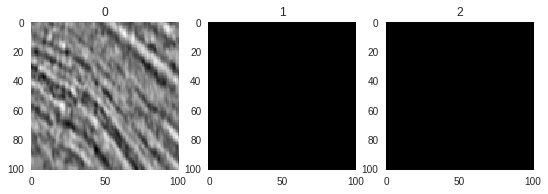

Image ID: 797


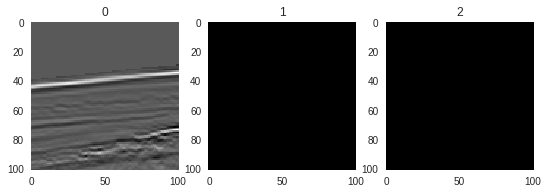

Image ID: 795


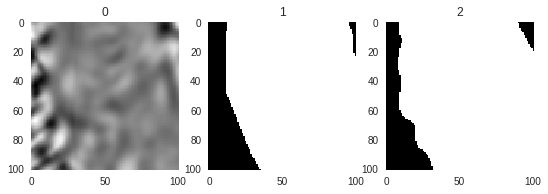

Image ID: 791


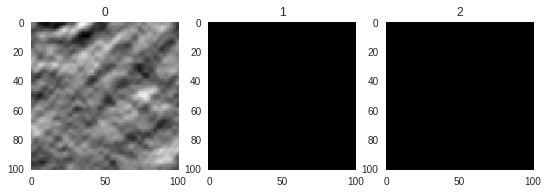

Image ID: 788


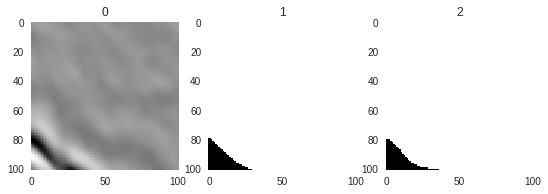

Image ID: 793


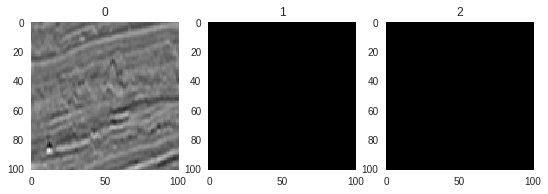

Image ID: 798


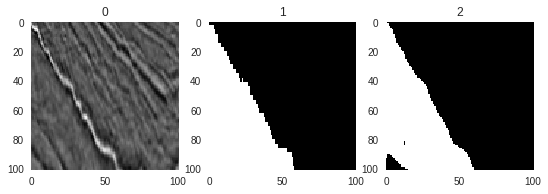

Image ID: 792


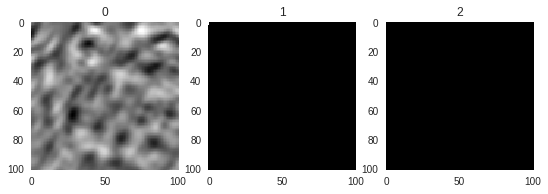

Image ID: 796


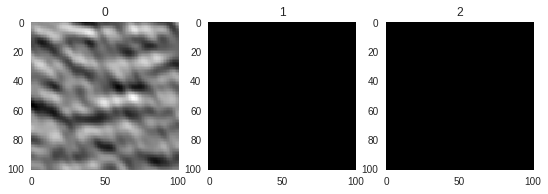

Image ID: 796


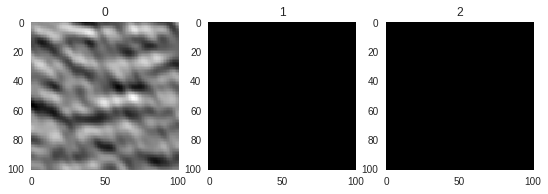

In [35]:
for i in range(10):
    rand_id = np.random.choice(X_val_id_batch)
    print(f'Image ID: {rand_id}')
    val_img = X_val[rand_id]/255
    val_mask = y_val[rand_id]
    val_mask_pred = y_val_pred.ge(0.5)[rand_id]
    plot_img_mask_pred([val_img, val_mask, val_mask_pred], range(3), img_per_line=3)

Image ID: 3194


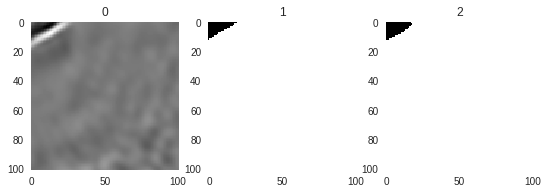

Image ID: 3195


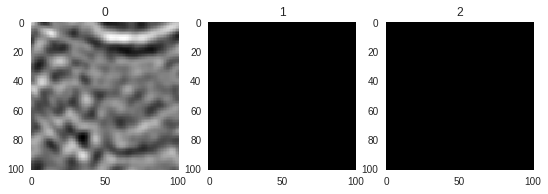

Image ID: 3189


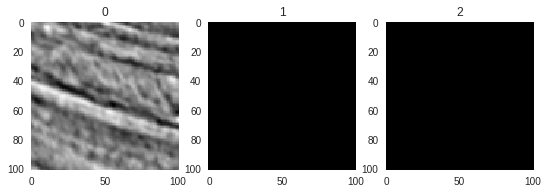

Image ID: 3193


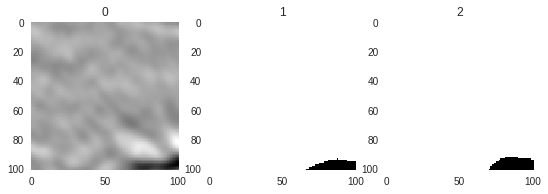

Image ID: 3193


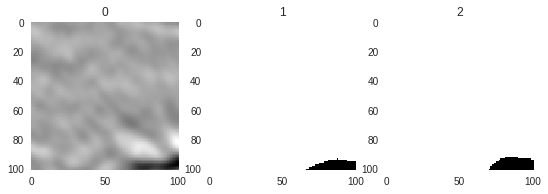

Image ID: 3193


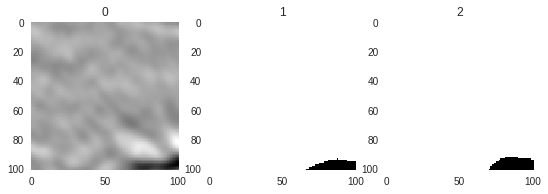

Image ID: 3184


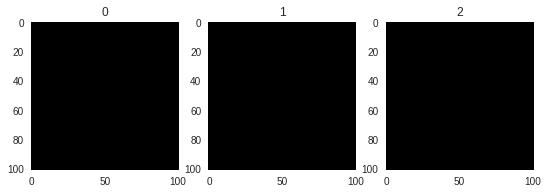

Image ID: 3189


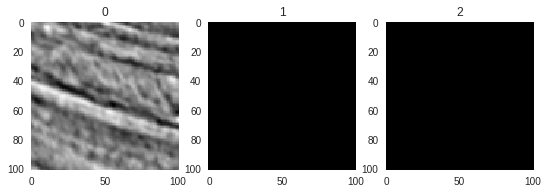

Image ID: 3196


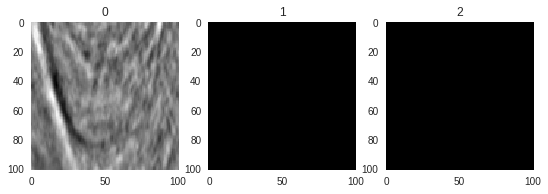

Image ID: 3189


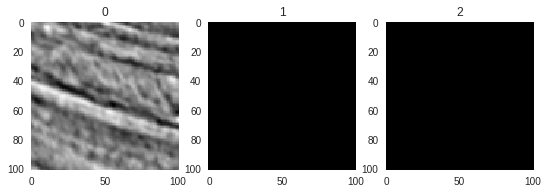

In [37]:
for i in range(10):
    rand_id = np.random.choice(X_train_id_batch)
    print(f'Image ID: {rand_id}')
    img = X_train[rand_id]/255
    mask = y_train[rand_id]
    mask_pred = y_train_pred.ge(0.5)[rand_id]
    plot_img_mask_pred([img, mask, mask_pred], range(3), img_per_line=3)

In [ ]:
ZERO_MASK_CUTOFF = 50
MASK_CUTOFF = 0.

In [50]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze())

06/09/2018 01:27:34 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.81525


In [42]:
y_val_pred_adj = adjust_predictions(0, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze())

06/09/2018 01:22:50 - SaltNet - INFO - IOU score before: 0.81025, IOU Score after:0.81025


In [52]:
results=[]
for cut_off in range(0, 300, 10):
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(cut_off, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze()), y_val.squeeze()))

0


06/09/2018 01:28:11 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.8142500000000001


10


06/09/2018 01:28:11 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.8142500000000001
06/09/2018 01:28:11 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.81525


20
30


06/09/2018 01:28:11 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.81525
06/09/2018 01:28:12 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.81525


40


06/09/2018 01:28:12 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.81525


50


06/09/2018 01:28:12 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.815


60


06/09/2018 01:28:13 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.815


70


06/09/2018 01:28:13 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.814625


80


06/09/2018 01:28:13 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.8134999999999999


90


06/09/2018 01:28:13 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.8134999999999999


100


06/09/2018 01:28:14 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.8128749999999999


110


06/09/2018 01:28:14 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.8128749999999999


120


06/09/2018 01:28:14 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.8121250000000001


130


06/09/2018 01:28:14 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.8121250000000001


140
150


06/09/2018 01:28:15 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.812
06/09/2018 01:28:15 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.809


160
170


06/09/2018 01:28:15 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.809


180


06/09/2018 01:28:16 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.80875


190


06/09/2018 01:28:16 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.80875


200


06/09/2018 01:28:16 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.80875


210


06/09/2018 01:28:16 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.80875


220


06/09/2018 01:28:17 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.808125
06/09/2018 01:28:17 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.808125


230
240


06/09/2018 01:28:17 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.809375


250


06/09/2018 01:28:18 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.809375


260


06/09/2018 01:28:18 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.809375


270


06/09/2018 01:28:18 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.809375


280


06/09/2018 01:28:19 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.8071250000000001


290


06/09/2018 01:28:19 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.80375


In [55]:
range(0, 300, 10)[np.argmax(results)]

20

In [ ]:
results

In [56]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred.gt(MASK_CUTOFF), y_val.squeeze())

06/09/2018 01:30:18 - SaltNet - INFO - IOU score before: 0.8142500000000001, IOU Score after:0.81525


In [57]:
y_train_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_train, y_train_pred.gt(MASK_CUTOFF), y_train.squeeze())

06/09/2018 01:30:25 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.82021875


In [58]:
results=[]
for cut_off in range(0, 300, 10):
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(cut_off, X_train, y_train_pred.gt(MASK_CUTOFF), y_train.squeeze()), y_train.squeeze()))

0


06/09/2018 01:30:43 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.82125


10


06/09/2018 01:30:44 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.82134375


20


06/09/2018 01:30:45 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.8211562499999999


30


06/09/2018 01:30:46 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.820875


40


06/09/2018 01:30:47 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.8205312499999999


50


06/09/2018 01:30:48 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.82021875


60


06/09/2018 01:30:49 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.8199687499999999


70


06/09/2018 01:30:50 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.8189687500000001


80


06/09/2018 01:30:51 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.8180312500000001


90


06/09/2018 01:30:52 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.81696875


100


06/09/2018 01:30:54 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.8165


110


06/09/2018 01:30:55 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.8155625000000001


120


06/09/2018 01:30:56 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.81525


130


06/09/2018 01:30:57 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.8148750000000001


140


06/09/2018 01:30:58 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.81359375


150


06/09/2018 01:30:59 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.81290625


160


06/09/2018 01:31:00 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.8124687500000001


170


06/09/2018 01:31:01 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.81203125


180


06/09/2018 01:31:02 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.81090625


190


06/09/2018 01:31:03 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.81078125


200


06/09/2018 01:31:04 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.8100937500000001


210


06/09/2018 01:31:05 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.8097187500000002


220


06/09/2018 01:31:06 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.8094062500000001


230


06/09/2018 01:31:07 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.80890625


240


06/09/2018 01:31:08 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.8086250000000001


250


06/09/2018 01:31:09 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.8077187499999999


260


06/09/2018 01:31:10 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.80734375


270


06/09/2018 01:31:11 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.8069375


280


06/09/2018 01:31:12 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.80625


290


06/09/2018 01:31:13 - SaltNet - INFO - IOU score before: 0.82125, IOU Score after:0.80571875


In [59]:
range(0, 3000, 10)[np.argmax(results)]

10

## Make predictions on test set

In [ ]:
#test_dataLoader = DataLoader(SaltDataset(np_test[:10], None, depth_test, X_train_mean_img), batch_size=4)
test_dataLoader = DataLoader(SaltDataset(X_test, np.zeros_like(X_test), depth_test, X_train_mean_img, out_size=128), batch_size=16)

In [61]:
y_test_pred_raw = []
with torch.no_grad():
    for X_test_batch, y_test_batch, depth_test_batch, X_test_id_batch in test_dataLoader:
        y_test_pred_raw.append(loaded_model(X_test_batch))
y_test_pred = torch.cat(y_test_pred_raw)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


### Show segmentation masks for a few images

Image ID: 17986


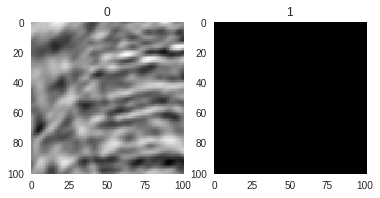

Image ID: 17984


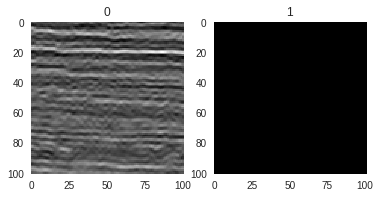

Image ID: 17996


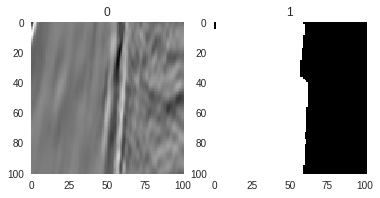

Image ID: 17985


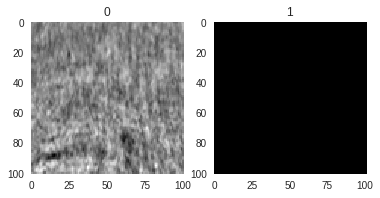

Image ID: 17988


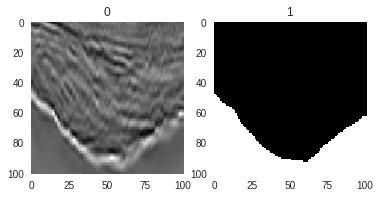

Image ID: 17991


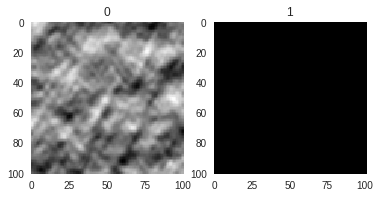

Image ID: 17996


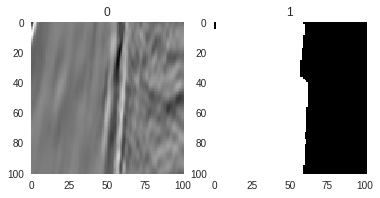

Image ID: 17999


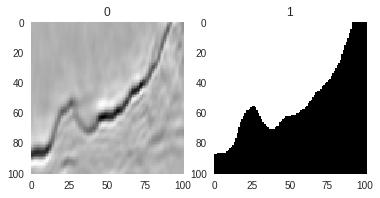

Image ID: 17994


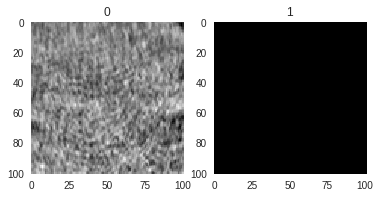

Image ID: 17999


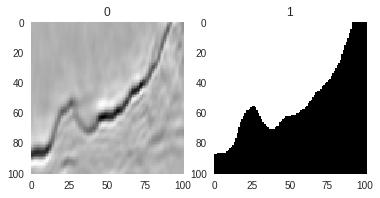

In [62]:
for i in range(10):
    rand_id = np.random.choice(X_test_id_batch)
    print(f'Image ID: {rand_id}')
    img = X_test[rand_id]/255
    mask_pred = y_test_pred.ge(0.5)[rand_id]
    plot_img_mask_pred([img, mask_pred], range(2))

### Adjust predictions

In [ ]:
 ZERO_MASK_CUTOFF = 20

In [ ]:
y_test_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_test, y_test_pred.gt(MASK_CUTOFF))

### Encode predictions using RLE(Run Length Encoding) method

In [ ]:
y_test_pred_rle = rle_encoder3d(y_test_pred_adj)

In [67]:
y_test_pred_adj.shape

(18000, 101, 101)

In [ ]:
df_test_rle = pd.DataFrame(index=misc_data['np_test_ids'], data=y_test_pred_rle).reset_index()

In [ ]:
df_test_rle.columns = ['id', 'rle_mask']

In [70]:
df_test_rle[df_test_rle.rle_mask==''].shape

(8083, 2)

In [71]:
df_test_rle.shape

(18000, 2)

In [ ]:
df_test_rle.to_csv(f'submission_{get_current_time_as_fname()}.csv', index=False)

In [73]:
ls

logs/
submission_2018_09_06_11_44_03.csv
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-4-Of-5
Unet_bce_loss_bilinear_2018_09_02_09_43_10.ckp-chunk-5-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-4-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_11_59_40.ckp-chunk-5-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-1-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-2-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.ckp-chunk-3-Of-5
Unet_bce_loss_bilinear_data_augmentor_2018_09_03_12_00_31.c

In [ ]:
from google.colab import files


In [ ]:
files.download('submission_2018_09_06_11_44_03.csv') 

In [55]:
import numpy as np

0.390625